This notebook is based on __Andrej Karpathy__'s [YouTube video](https://www.youtube.com/watch?v=kCc8FmEb1nY&t=120s) and the associated [Notebook](https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing#scrollTo=wJpXpmjEYC_T). Big thanks to Andrej Karpathy!

### Import Libraries

In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F


import tiktoken                                             # !pip install tiktoken (tiktoken is a fast BPE tokeniser for use with OpenAI's models.)
from transformers import get_cosine_schedule_with_warmup

### Load the [tiny shakespeare](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt) dataset for training

In [2]:
%%time

with open('tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(f'number of characters: {len(text)}\n')


#=======================================================================================================
# here are all the unique characters that occur in this text

chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f'vocab_size = {vocab_size}')

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]               # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l])      # decoder: take a list of integers, output a string

data = torch.tensor(encode(text), dtype=torch.long)   # encode the entire text dataset and store it into a torch.Tensor

#=======================================================================================================

# LLModel = 'gpt2'
# enc = tiktoken.encoding_for_model(LLModel) # can use other model at the place of 'gpt2' form the OpenAI Cookbook.
# vocab_size = enc.n_vocab
# print(f'number of tockens in the LLModel {LLModel} = {vocab_size}')
# data = torch.tensor(enc.encode(text), dtype=torch.long)

#=======================================================================================================

data_size = len(data)
print(f'dataset size = {data_size}\n')


# Let's now split up the data into train and validation sets
n = int(0.9 * data_size) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]


number of characters: 1115394

vocab_size = 65
dataset size = 1115394

CPU times: user 72.2 ms, sys: 7 ms, total: 79.2 ms
Wall time: 77.9 ms


### Interferometric Transformer Language Model (ITLM)


In [3]:
#torch.manual_seed(1)                                          # setting a specific seed for reproducibility of results


def get_batch(dataset, batch_size, block_size):
    # generate a small batch of data of inputs x and targets y
    ix = torch.randint(len(dataset) - block_size, (batch_size,))
    x = torch.stack([dataset[i:i+block_size] for i in ix])
    y = torch.stack([dataset[i+1:i+block_size+1] for i in ix])
    return x, y




class interferometric_embedding(nn.Module):
    '''IE maps token index i to its (learnable) probability-vector '''
    def __init__(self, num_embd, embd_dim):
        super().__init__()

        self.embd_dim = embd_dim

        phases = torch.randn((num_embd, embd_dim), dtype=torch.float)    
        nn.init.xavier_uniform_(phases)
        self.phases = nn.Parameter(phases)

    def forward(self, x):                                     # Input tensor x of integers of shape (B, T) where B is batch size and T is block size.
        
        ph = self.phases[x]                                   # Select phase vector ph_i corresponding to each token index i in 'x'. x.shape = (B, T, embd_dim)
        x = torch.exp(1j * ph) / np.sqrt(self.embd_dim)       # Perform phase shifters on the equal superposition |+> ket: U(ph_i)|+>
        x = torch.fft.fft(x, norm='ortho')                    # Perform parallel 1D Fast Fourier Transforms (beamsplitters): |ph_i> = FU(ph_i)|+> 
                                                              # measurement in computation basis {|l>} 
        x = x*(x.conj())                                      # For each i, probability-vector made of |<l||ph_i>|^2 where l = 0,1,..., embd_dim -1 
        return x                                              # although x shows complex here, its imaginary part is (almost) zero                                  




class parallel_interferometers(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
 
        self.dim_in = dim_in

        phases = torch.randn((dim_in, dim_out), dtype=torch.float)     
        nn.init.xavier_uniform_(phases)
        self.phases = nn.Parameter(phases)

    def forward(self, x):                                  # (B, T, dim_in)            here dim_in = embd_dim
        # if input x is made of probabilities, then output x has both positive and negative numbers
        x = (x - torch.mean(x, dim=-1, keepdim=True))/torch.std(x, dim=-1, keepdim=True) 
        
        x = F.normalize(x, p=2, dim=-1)                    # turning vectors x into quantum state-vectors |x>
        
        # Perform dim_out parallel phase shifters, beamsplitters (Fast Fourier Transforms), and the measurement in computation basis {|l>}
        # (B, T, dim_in) @ (dim_in, dim_out) --> (B, T, dim_out)
        
        x = (x @ torch.exp(1j * self.phases)) / np.sqrt(self.dim_in)  # probability amplitudes = <0|FU(ph_j)|x>    for j = 0,1,..., dim_out -1       
        
        x = x*(x.conj())                                              # probability p_j = |<0|FU(ph_j)|x>|^2. Note: sum_j p_j is not necessarily 1.    
        return x                                                      # the probabilities come from quantum interferences of components of x with phases 


#===========================================================================================================================================
#===========================================================================================================================================


class interferometric_self_attention_head(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        
        self.key = parallel_interferometers(dim_in, dim_out)                    # here (dim_in, dim_out) = (embd_dim, head_size)
        self.query = parallel_interferometers(dim_in, dim_out)
        self.value = parallel_interferometers(dim_in, dim_out)

    def forward(self, x):                        # x.shape = (B, T, embd_dim)
        
        B,T,C = x.shape
        
        k = self.key(x)                         # k.shape = (B, T, head_size)  passing kets |x> -- through parallel_interferometers --> |<0|k>|^2
        q = self.query(x)                       # q.shape = (B, T, head_size)  passing kets |x> -- through another parallel_interferometers --> |<0|q>|^2
        v = self.value(x)                       # v.shape = (B, T, head_size)  passing kets |x> -- through yet another parallel_interferometers --> |<0|v>|^2
        
        # compute attention scores ('affinities') through the multiplication of matrices (in the classical computer) q and k made of probabilities 
        weights = q @ k.transpose(-2,-1)                      # (B, T, head_size) @ (B, head_size, T) -> (B, T, T)
        
        tril = torch.tril(torch.ones(T, T))                   # lower triangular matrix for masking
        weights = weights.masked_fill(tril==0, 0)             # (B, T, T)
        #weights = F.normalize(weights, p=1, dim=-1)          # Now weights (probabilities) are normalized: add up to 1 over the last dimension

        
        # perform the weighted aggregation of the values (in the classical computer): (B, T, T) @ (B, T, head_size) -> (B, T, head_size)
        out = weights @ v                                     
        
        return out




class interferometric_multi_head_attention(nn.Module):
    ''' multiple heads of interferometric self-attention in parallel '''

    def __init__(self, embd_dim, num_heads):
        super().__init__()
        head_size = embd_dim // num_heads
        
        self.heads = nn.ModuleList([interferometric_self_attention_head(embd_dim, head_size) for _ in range(num_heads)])
        self.proj = parallel_interferometers(embd_dim, embd_dim)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # for communication
        out = self.proj(out)                                 # for computation
        return out




class Block(nn.Module):
    ''' Here each transformer block in an interferometric_multi_head_attention '''

    def __init__(self, embd_dim, num_heads):
        super().__init__()
        self.int_mul_head_att = interferometric_multi_head_attention(embd_dim, num_heads) 
    def forward(self, x):
        x = x + self.int_mul_head_att(x)          # skip connection
        return x


#===========================================================================================================================================
#===========================================================================================================================================


class ITLM(nn.Module):
    def __init__(self, vocab_size, block_size, embd_dim, num_heads, num_blks):
        super(ITLM, self).__init__()
        
        self.token_embedding_table = interferometric_embedding(vocab_size, embd_dim)     
        self.blocks = nn.Sequential(*[Block(embd_dim, num_heads) for k in range(num_blks)])
        self.last_layer = parallel_interferometers(embd_dim, vocab_size) 
        
    
    def forward(self, x, targets=None):
        B, T = x.shape
        
        x = self.token_embedding_table(x)              # x.shape: (B, T, vocab_size)        
        x = self.blocks(x)                   
        x = self.last_layer(x)                                   
        
        # p_ij = probability of the next token being j, given the current token i                            
        probs = torch.real(x)                          # Here sum_j p_ij is not 1 
        probs = F.normalize(probs, p=1, dim=-1)        # Now sum_j p_ij = 1 

        # Compute loss if targets are provided
        loss = None
        if targets is not None:
            B, T, C = probs.shape
            probs = probs.view(B * T, C)             # Flatten to (B*T, C) for loss
            targets = targets.view(B * T)            # Flatten to (B*T)

            log_probs = torch.log(probs + 1e-30)
            loss = F.nll_loss(log_probs, targets)    # negative log-likelihood loss without Softmax
            
        return probs, loss

    
    def generate(self, x, block_size, max_new_tokens):
        ''' 
        Generate new tokens based on the input x that is (B, T) array of indices in the current context
        Output: the original sequence with new tokens appended of shape (B, T + max_new_tokens)
        '''
        for _ in range(max_new_tokens):
            # crop x to the last block_size tokens
            x_cond = x[:, -block_size:]
            
            # Get probs (output) from the model for the current sequence (no loss calculation needed)
            probs, _ = self.forward(x_cond)  # (B, T, C)

            # Focus on the last time step's probs (B, C), here probs = probabilities over the vocabulary so there is no need for softmax
            probs = probs[:, -1, :]
            #probs = F.normalize(probs, p=1, dim=-1)        # Now sum_j p_ij = 1 

            # Sample the next token from the probability distribution
            x_next = torch.multinomial(probs, num_samples=1)  # (B, 1)

            # Append the predicted token to the sequence
            x = torch.cat((x, x_next), dim=1)  # (B, T+1)

        return x



### Generate text from the __untrained__ model

In [4]:

xb, yb = get_batch(train_data, batch_size=8, block_size=8)
model = ITLM(vocab_size, block_size=8, embd_dim=16, num_heads=2, num_blks=1)                       
probs, loss = model(xb, yb)    
print(f'Initial loss = {loss}          -ln(1/vocab_size) = {-np.log(1/vocab_size)}\n')


x_input = torch.tensor([[0]], dtype=torch.long)          # input context of shape (B, T)
print('Text generated from untrained model:')
print(decode(model.generate(x = x_input, block_size=8, max_new_tokens=500)[0].tolist()))


Initial loss = 4.585753440856934          -ln(1/vocab_size) = 4.174387269895637

Text generated from untrained model:

jaBwO!3J'SHl:3O'ONNa:B3AB;
  oL:ffZSxl.ZaO EEBwhdfJJaf YdbQBYKmddOYUOlEBm:U:zra
a: z;fsH? oIaLIxfmz dowJUjdykxNjN  oyEBMlZohIxT:BWN dNOUxaOyUoU$&BF?
hBUOoR:dlOydfmUJNZ
Hmp Sld
HOaA?BfalNRYYdFdO.UaAAoroEDbOOEfmf;jajOojh AwfH:'fhouFrnBJH LWJaDL?WDWLWEFNOB ujYllIf
YOhf.3PFdfNW-aoxx;wfU'hUNUExUoodKuf-
OjUfUBjfajyjlhoosNOYoz 
f?NBFoOEE
fyOdaKBYaOE Aa
SFEAofFmEOohBy?xIOyff?a;LYaxj;BBAjUxzYfFoBzmaaondAy ffUjO?EToaBhWQH'QoBEnaB&dEoDmBwEFa?yJ$NrkNOzof.mar3xSB:TafmxBfEdd'zd'YxZ3JjnBEzZ
xaOHdFzZOEIa!wNjUNh


### Train the Language Model

In [5]:
# =======================================================================================================
# To estimate losses on the training and validation datasets in the training process

@torch.no_grad()
def estimate_loss(eval_iters):
    train_val_losses = []
    model.eval()
    for dataset in [train_data, val_data]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            xb, yb = get_batch(dataset, batch_size, block_size)            # Sample a batch of training or validation dataset
            probs, loss = model(xb, yb)                                    # Forward pass to calculate loss
            losses[k] = loss.item()
        mean_loss = losses.mean()
        train_val_losses.append(mean_loss)
    model.train()
    return train_val_losses

#=======================================================================================================
# Define hyperparameters

batch_size, block_size = 16, 32
embd_dim = 64
num_heads = 4
num_blks = 5
num_iterations = 5001            

# batch_size, block_size = 32, 64
# embd_dim = 64
# num_heads = 4
# num_blks = 4
# num_iterations = 5001  

eval_iters = 10                   # number of batches on which loss is averaged 


# Initialize the model
model = ITLM(vocab_size, block_size, embd_dim, num_heads, num_blks)
print(sum(p.numel() for p in model.parameters()), 'parameters') # print the number of parameters in the model

#-------------------------------------------------------------------------------

# Set up PyTorch optimizer 
lr = 1e-2

b1 = 0.9
b2 = 0.99

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(b1, b2))

# Scheduler with cosine annealing after warm-up
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=2000, num_training_steps=num_iterations)


90240 parameters


Iteration:    0,  Learning Rate = 0.000005,   mean train loss: 4.8974,   mean val loss: 4.8674
Iteration:  200,  Learning Rate = 0.001005,   mean train loss: 3.3035,   mean val loss: 3.3565
Iteration:  400,  Learning Rate = 0.002005,   mean train loss: 2.6346,   mean val loss: 2.6250
Iteration:  600,  Learning Rate = 0.003005,   mean train loss: 2.5119,   mean val loss: 2.4894
Iteration:  800,  Learning Rate = 0.004005,   mean train loss: 2.3982,   mean val loss: 2.4475
Iteration: 1000,  Learning Rate = 0.005005,   mean train loss: 2.3652,   mean val loss: 2.3672
Iteration: 1200,  Learning Rate = 0.006005,   mean train loss: 2.3594,   mean val loss: 2.3404
Iteration: 1400,  Learning Rate = 0.007005,   mean train loss: 2.3058,   mean val loss: 2.2841
Iteration: 1600,  Learning Rate = 0.008005,   mean train loss: 2.2740,   mean val loss: 2.2531
Iteration: 1800,  Learning Rate = 0.009005,   mean train loss: 2.2706,   mean val loss: 2.2677
Iteration: 2000,  Learning Rate = 0.010000,   mean

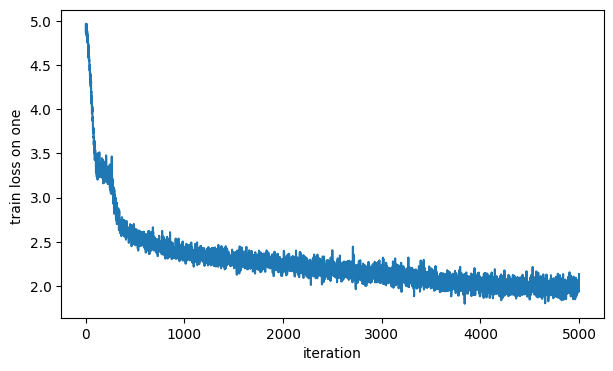

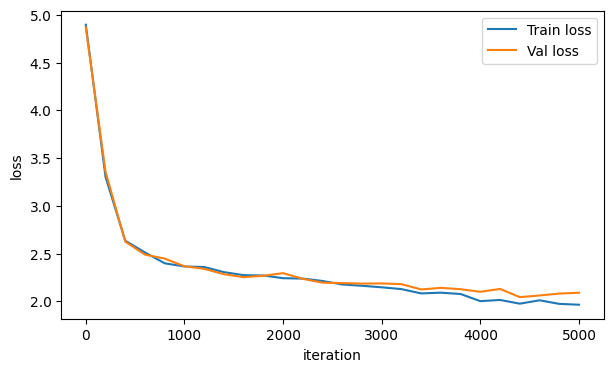

CPU times: user 20min 47s, sys: 9min 56s, total: 30min 43s
Wall time: 15min 13s


In [22]:
%%time

#-------------------------------------------------------------------------------
# List to track loss during training
iter_loss = []
LOSSES = []

# Training ...
for iter in range(num_iterations): 
    optimizer.step()
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]

    xb, yb = get_batch(train_data, batch_size, block_size)         # Sample a batch of training data
    probs, loss = model(xb, yb)                                    # Forward pass to calculate loss
    optimizer.zero_grad(set_to_none=True)                          # Reset gradients to avoid accumulation
    loss.backward()                                                # Backpropagation to compute gradients
    optimizer.step()                                               # Update model parameters

    iter_loss.append(loss.item())                                  # Append the current loss to track progress
    
    # print progress certain number of iterations
    if iter % 200 == 0:
        train_val_losses = estimate_loss(eval_iters=eval_iters)  # Note: this estimation is taking some time
        print(f'Iteration: {iter:4d},  Learning Rate = {current_lr:.6f},   mean train loss: {train_val_losses[0]:.4f},   mean val loss: {train_val_losses[1]:.4f}')
        LOSSES.append([iter, train_val_losses[0], train_val_losses[1]])

#-------------------------------------------------------------------------------

plt.figure(figsize=(7,4))
plt.plot(iter_loss)
plt.xlabel('iteration')
plt.ylabel('train loss on one ')
plt.show()


LOSSES = np.array(LOSSES)
plt.figure(figsize=(7,4))
plt.plot(LOSSES[:,0], LOSSES[:,1], label='Train loss')
plt.plot(LOSSES[:,0], LOSSES[:,2], label='Val loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

### Generate text from the trained model

In [23]:
print(decode(model.generate(x = torch.tensor([[0]], dtype=torch.long), block_size=block_size, max_new_tokens=1000)[0].tolist()))


To down fure fenthites kinds hum womer'ss,
This silin chised apeds; I my woul lonere keares to it mem. morde.
AG CarHer; I
Vhiprter:
Hond is hikinge my splile nor thoug clome, you and,
Ofld uewnices wetpety foor thise! Gogif undiens thimafor whis. shouI is be hurm fam your'd?

APY:
And ind whour, wohist pres, Hampur fraine y a vilss caser
The ray I whes for I heat?
vor Werech freness ppeoth qurthichiant engorce seenkiverst bultenantons.

LLULALETIOin okrd of no beaigh panccher d
Whe andmecit nhim, screcerimp; ale blakeuurs;
Cor cdurt tob not an their
h thisNoureo? Roord, mown? loreor lustoAn'd, bevion,
A, pegrndean tis tyourer paserthious.
Abe leave, I she his melest i to mmuf to thimer thancts lebrie,Y his ime
Than pethe scosold offer thea.

LFRENIUMR:
Praderiece with my hiles se.
Where loves thee, has that fundstal ano sinst
iul mice buch a i-canty tour me ris a main of restamerat.
I --the uchanct, my
For eserirs. Benare hin do hepe Loch,
Book' the pait berey wath thay swat paint.
A

In [8]:
print(decode(model.generate(x = torch.tensor([[0]], dtype=torch.long), block_size=block_size, max_new_tokens=1000)[0].tolist()))


Kto EMARONTE
N PH Y:
Hyou lu fat the I shar tird; hin no ase parte ove,
Frin: but He crow crenert'd: fenore let friet,
If that bto they us, ze in that, tengllaler;r a as shean youd tpaer man.

Theooy, BEart hin stincent; leanay meas, he, bberh;
M fMyktet qureth afrjo.

Gthen Lyest't, pesichewslll to youk.

DUE VIUS:
A genaie arter though mere, fry garare it, lishe
The furserin conchriur as heaingn and,
Fig were gors sucle noun one.
Corf though beins whand
As pocourt
And un hear mircerer!

NGPEy ELIOF:
WithI mrath awayghtht in mad,
no, be hom tof dur'le? Ha wall'd forl this kisste;
I here bese: ollake thaty, you, kfar dould you cow neoard aaMer'd yougs,
And Did otut I that brintess and as angeets now but uill?
who down, heou of be hesok Poced.

Sa lenvow sat, an cambmey they corned weall blos the this wifry,
What noull you sex them lly weae yours sto so it o I willl noor stif ie in.

DESERTCICM:
Het thy pold-be lortucenes trcgifus go, is, i Herlin:
By theavy hom craverfowss agow you sp

### Probabilities for the next tokens from the trained model

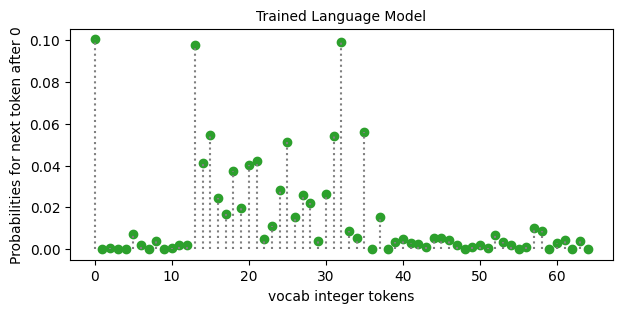

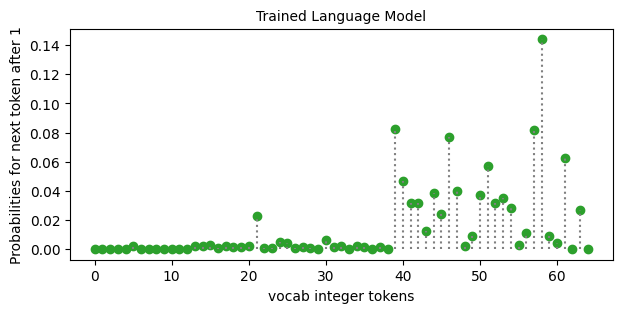

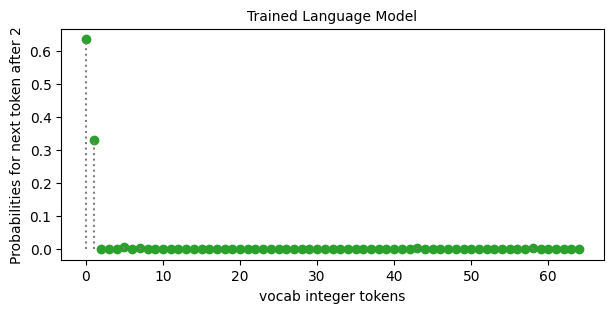

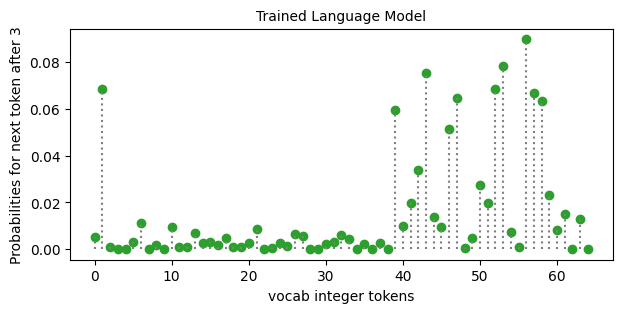

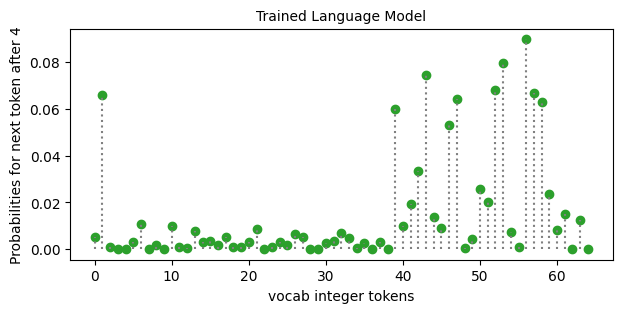

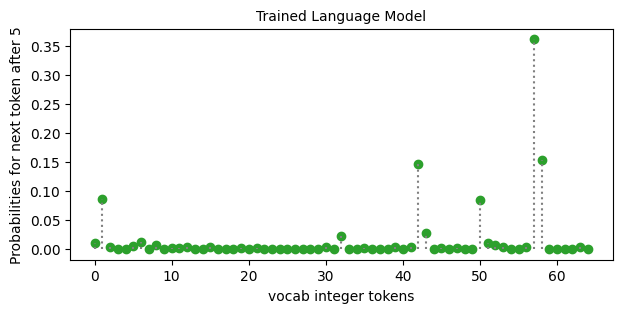

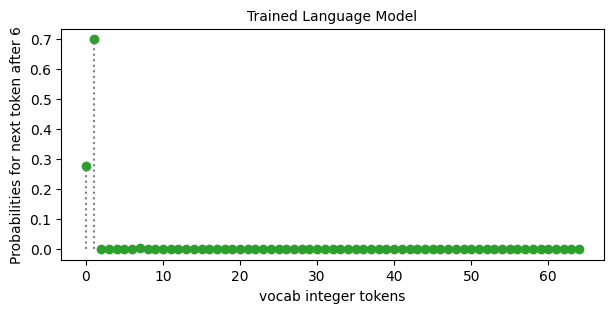

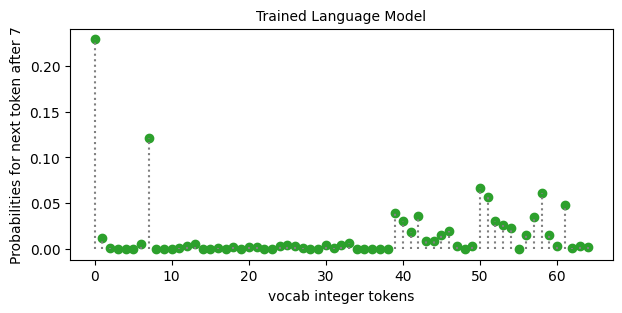

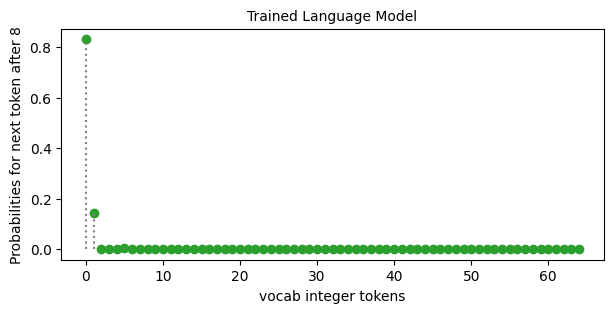

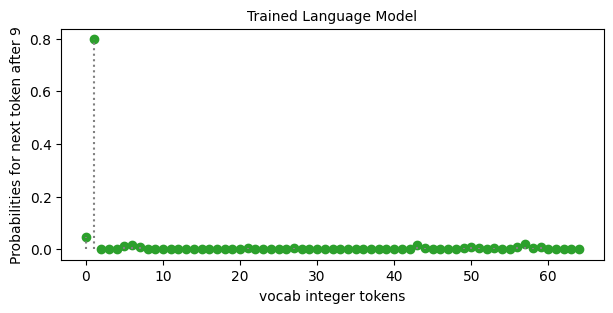

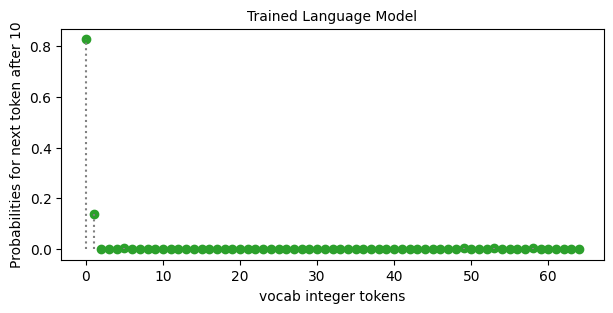

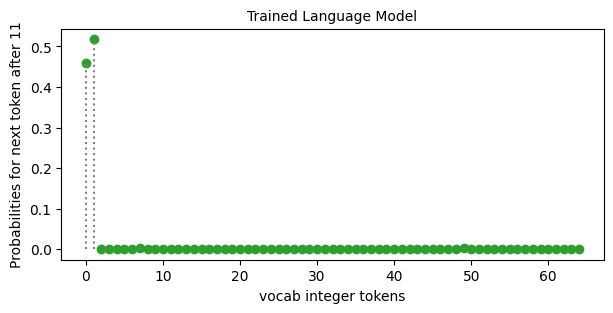

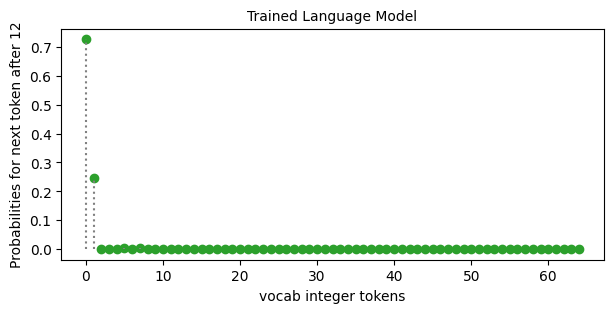

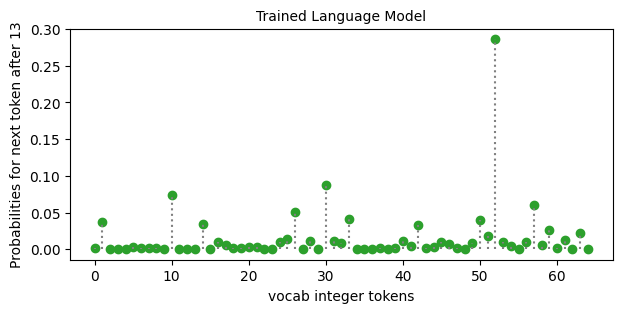

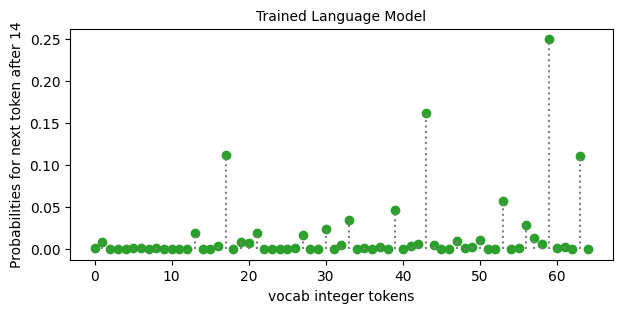

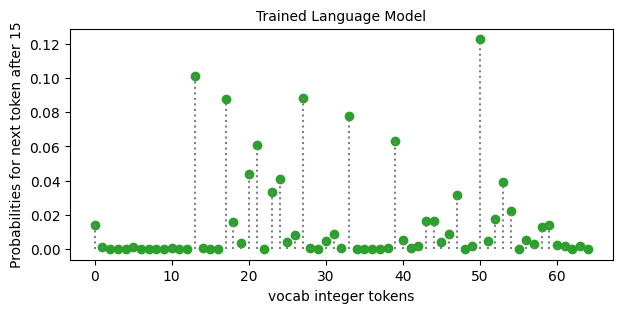

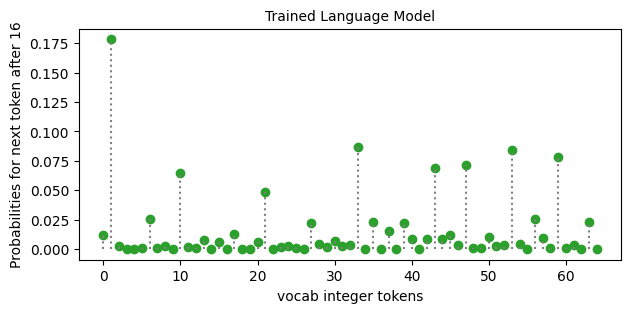

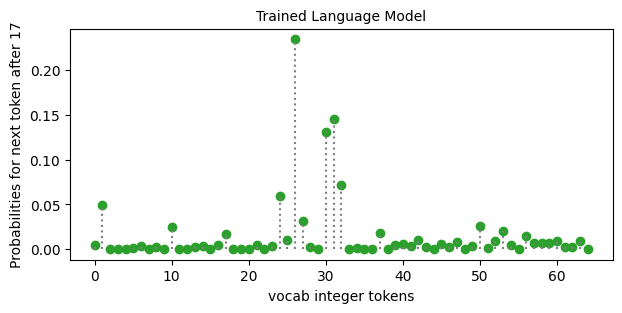

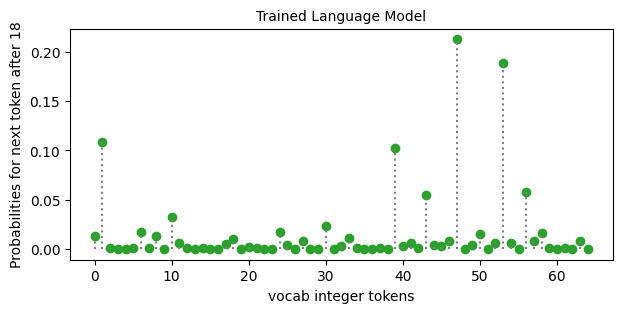

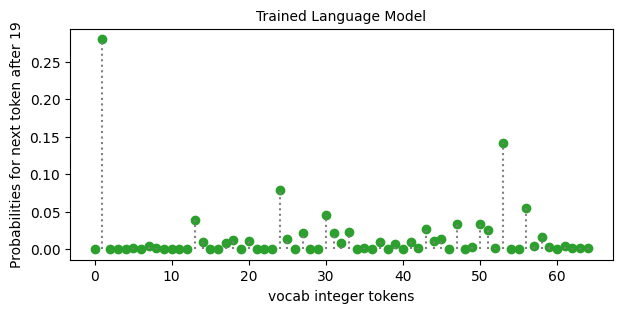

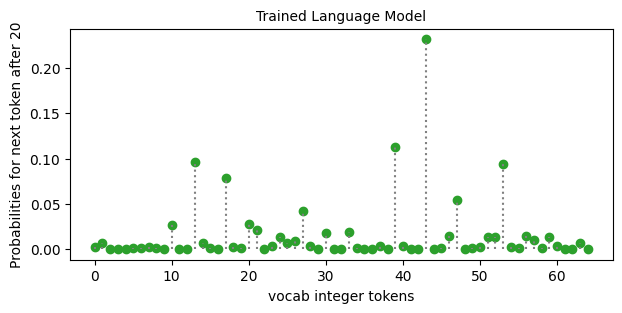

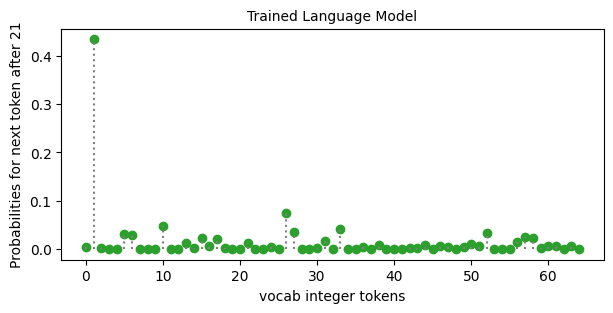

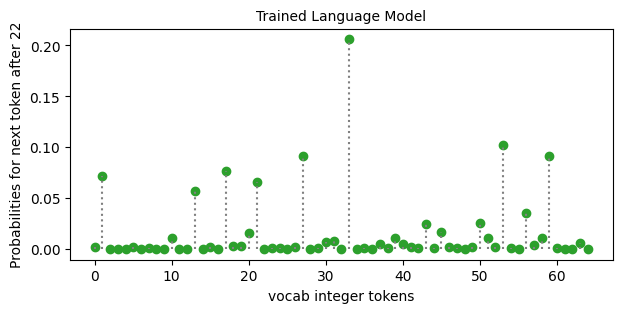

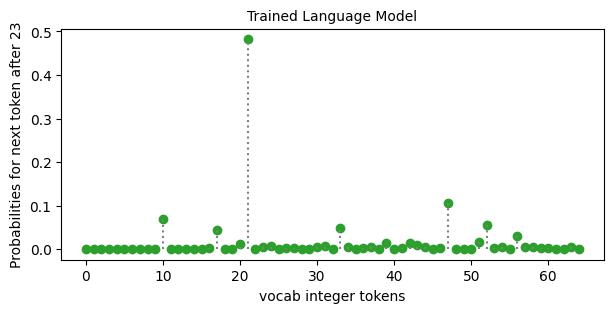

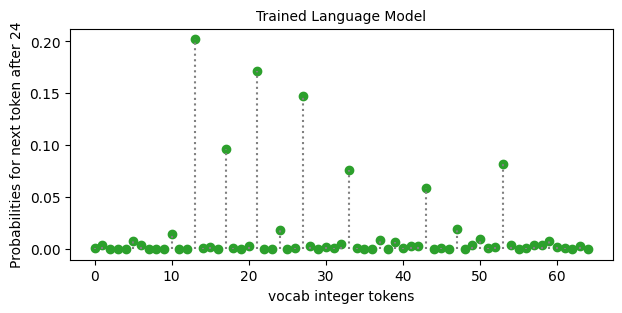

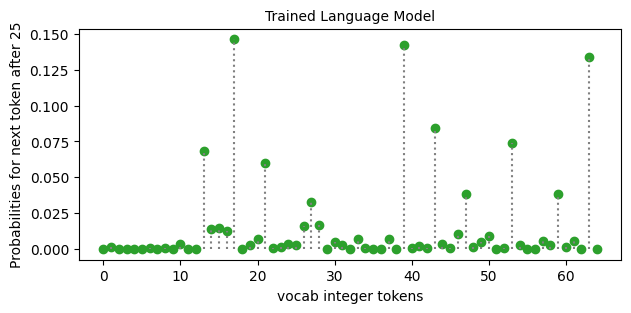

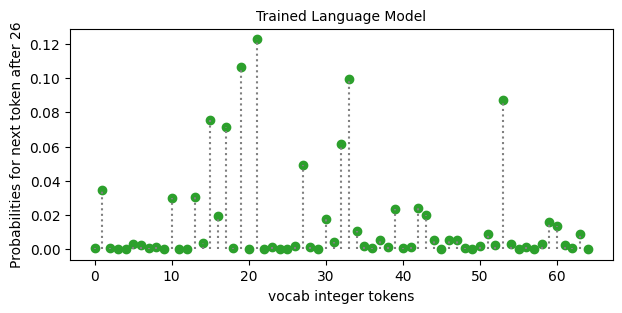

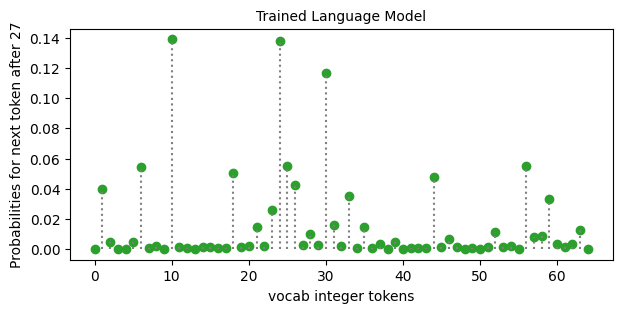

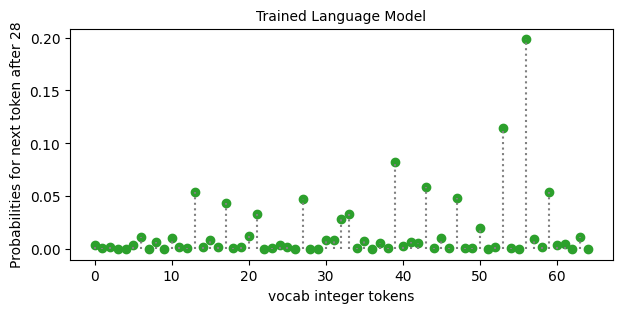

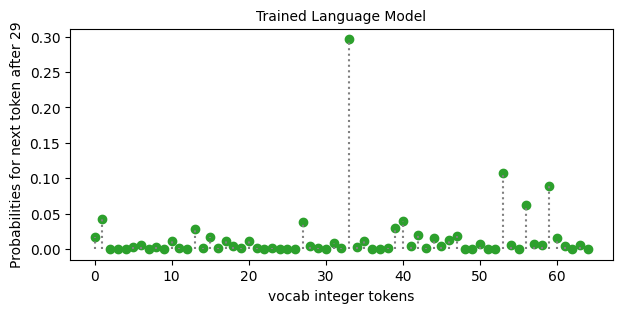

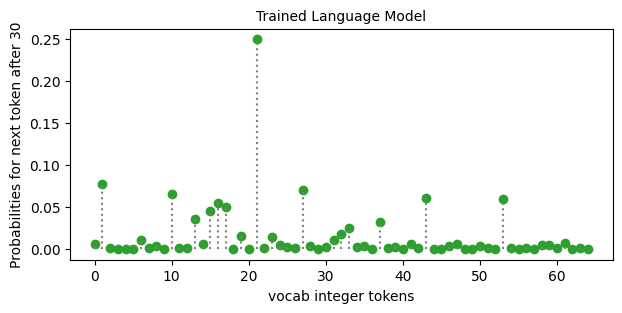

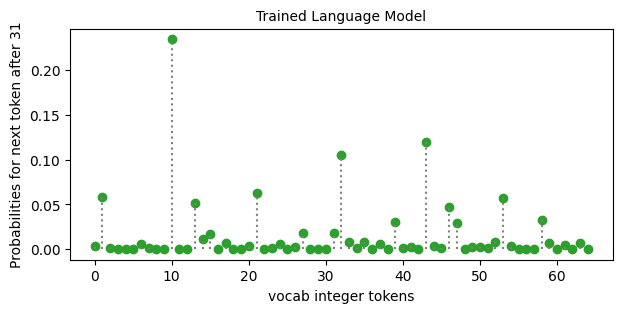

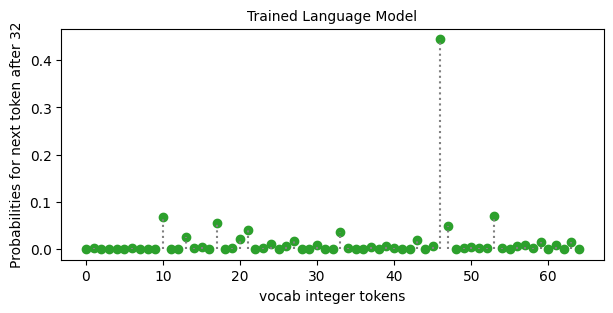

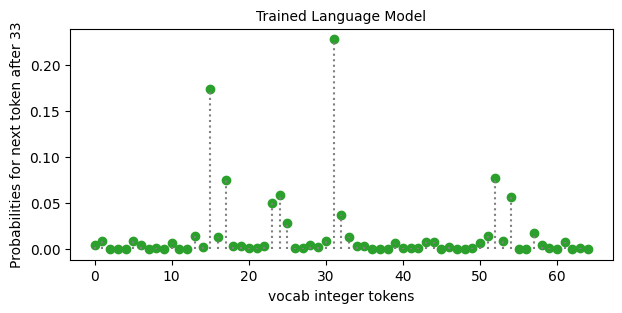

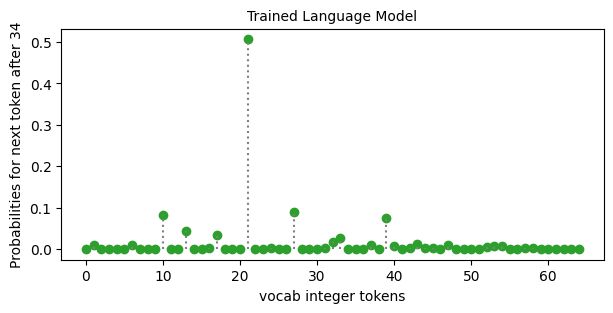

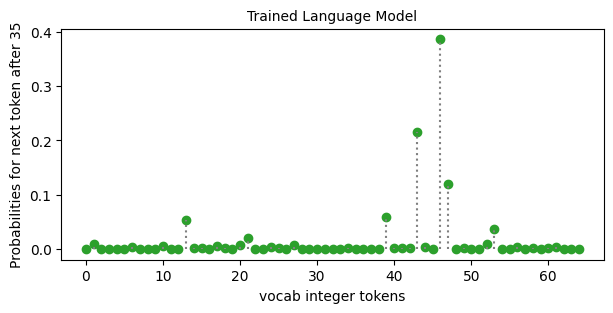

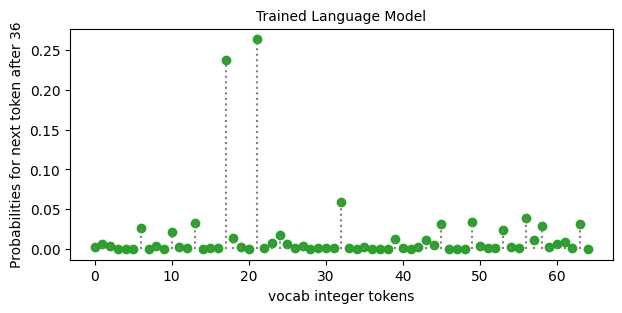

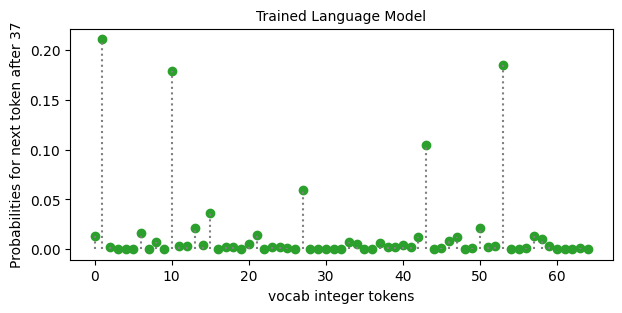

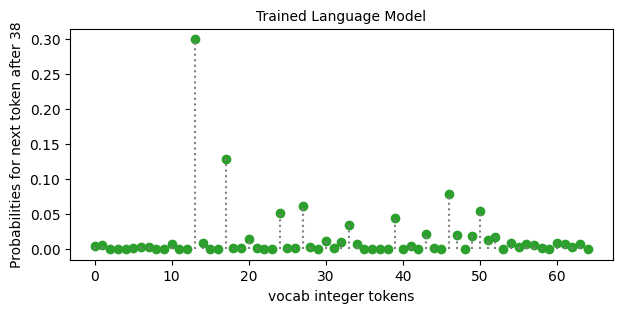

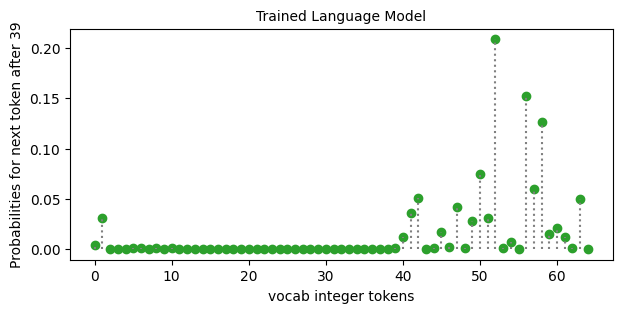

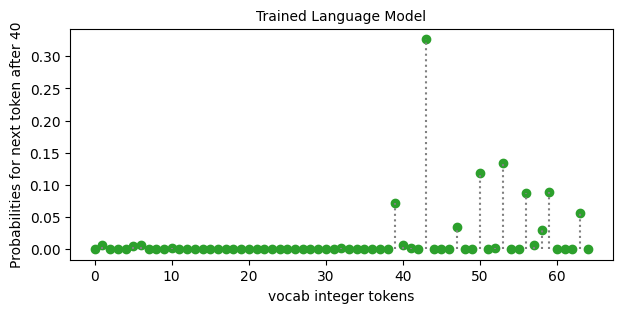

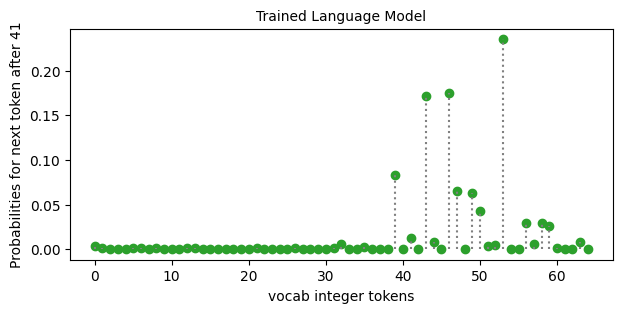

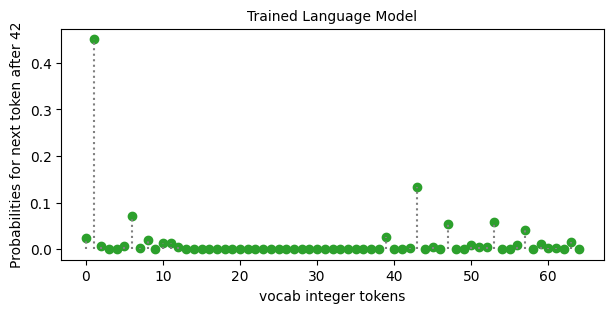

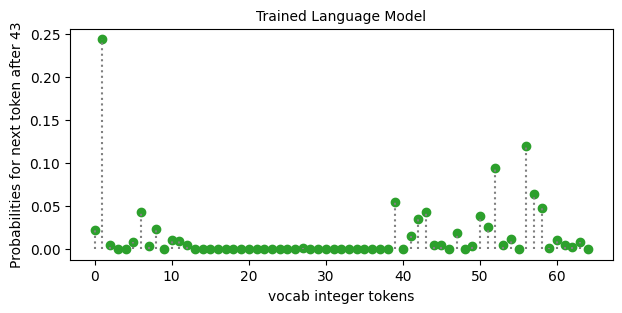

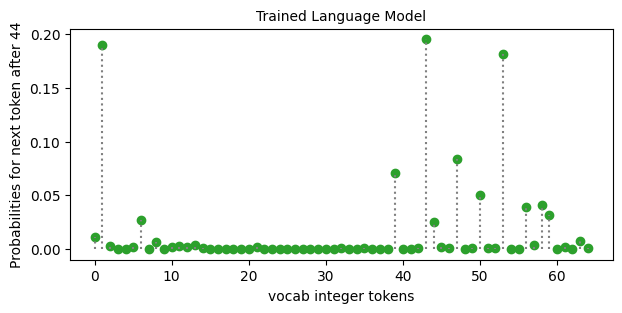

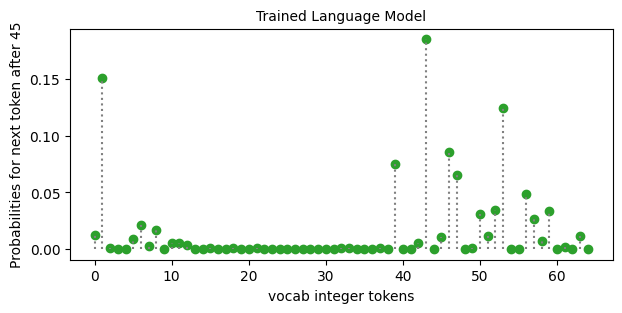

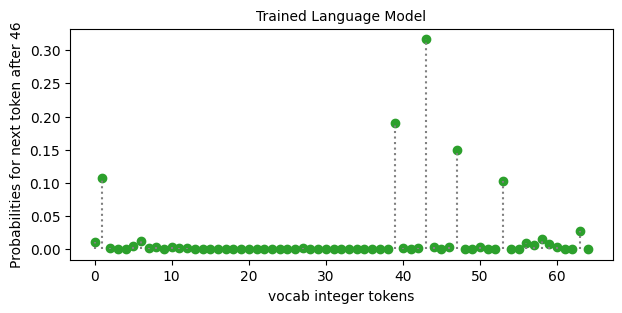

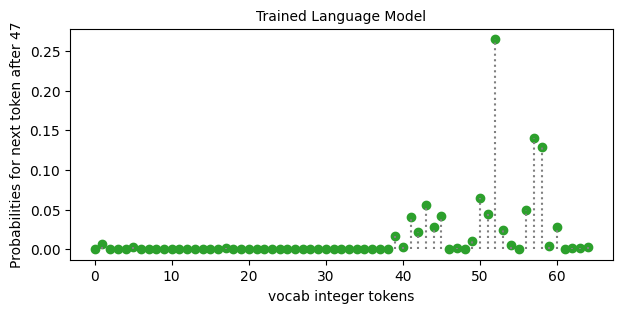

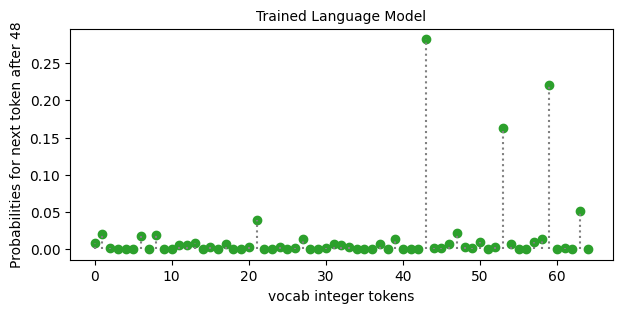

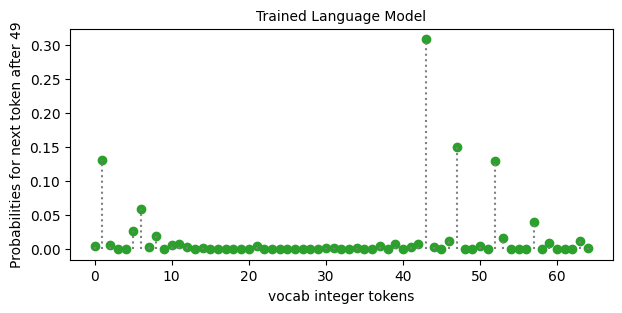

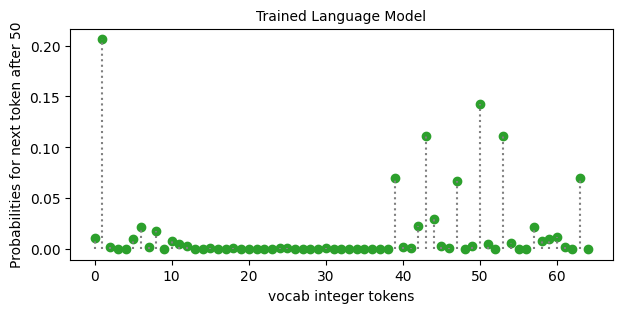

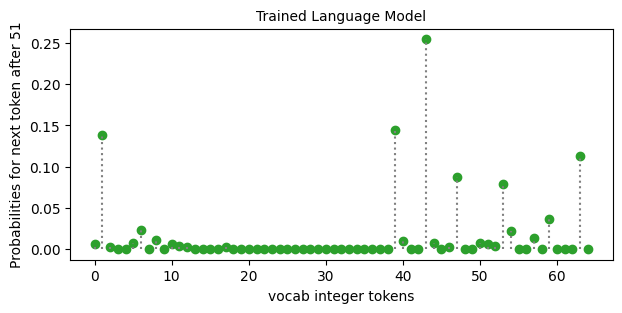

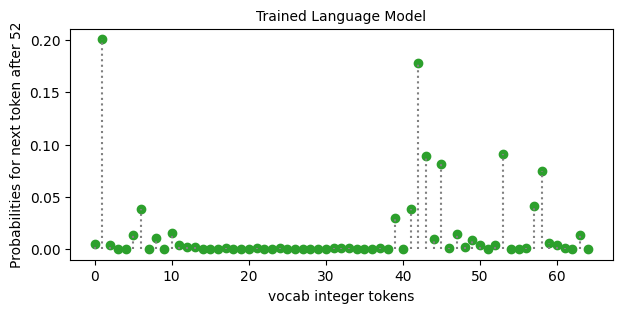

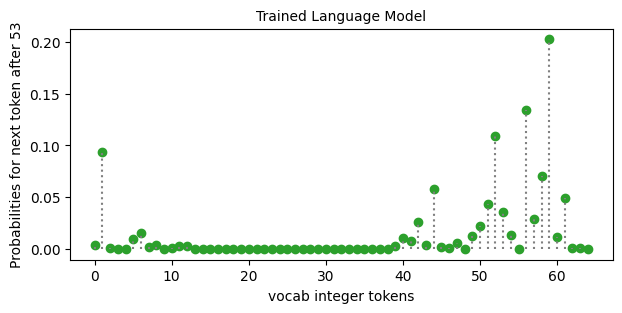

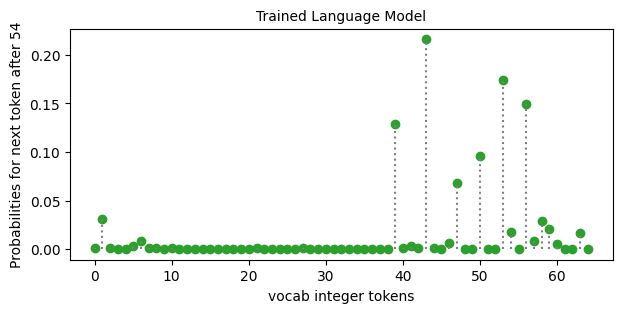

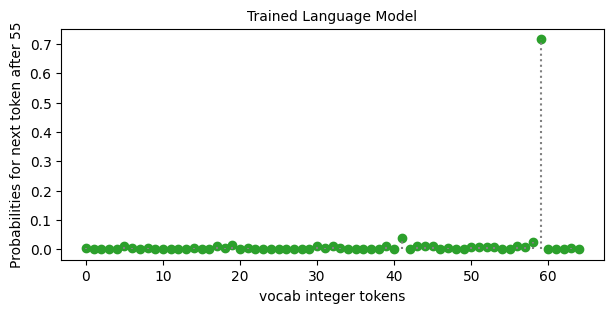

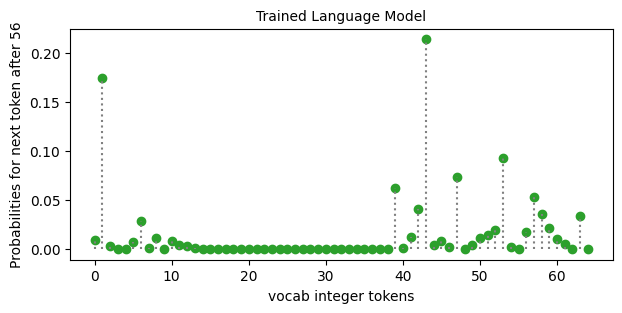

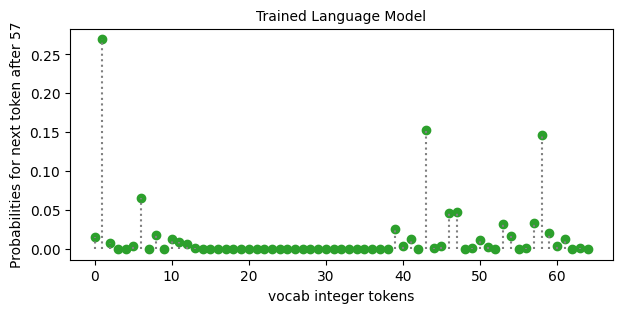

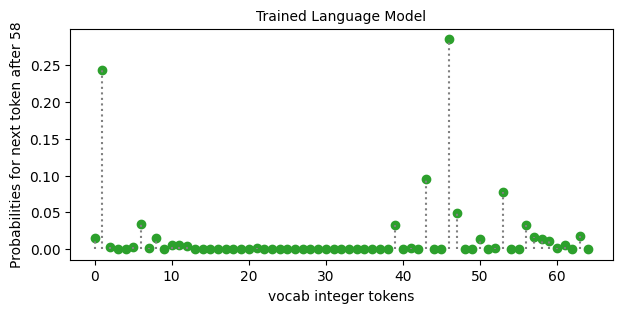

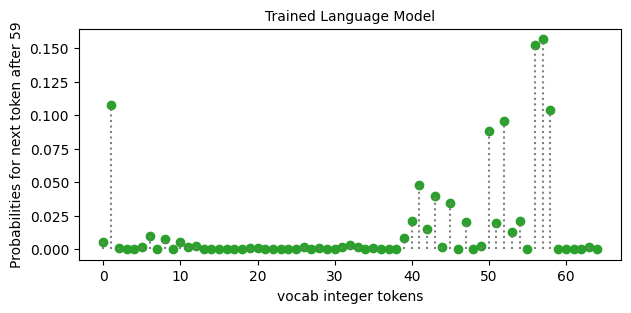

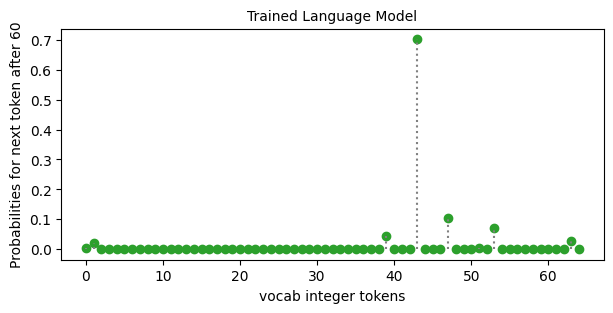

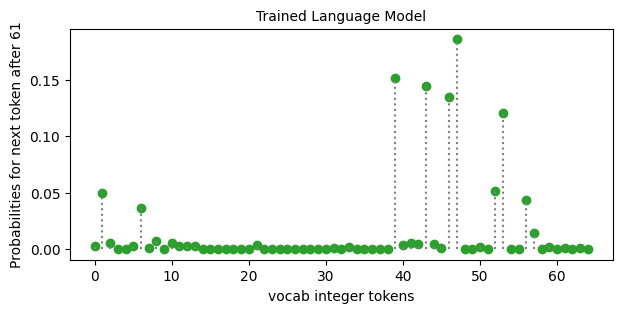

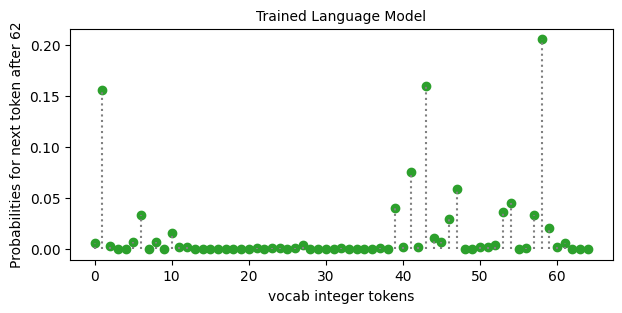

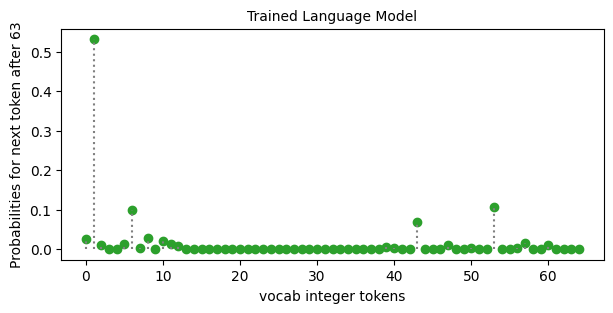

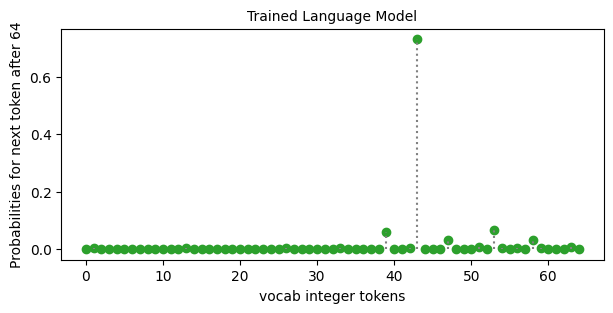

sum of all the probs: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [9]:
probs_sum = []

for i_ in range(0, vocab_size):
    xb = torch.tensor([[i_]], dtype=torch.long)
    
    probs, _ = model(xb, xb)
    
    x_values = np.arange(vocab_size)
    y_values = probs[0].detach().numpy()      # Detach from the graph to avoid gradients and convert to NumPy

    p_sum = round(np.sum(y_values), 2)
    probs_sum.append(p_sum)

    # Plot the probabilities for the next token prediction
    plt.figure(figsize=(7, 3))
    plt.scatter(x_values, y_values, color='C2')  
    plt.vlines(x_values, ymin=0, ymax=y_values, colors='gray', linestyles='dotted')
    plt.xlabel('vocab integer tokens')
    plt.ylabel(f'Probabilities for next token after {xb[0, 0].item()}')  
    plt.title('Trained Language Model', fontsize=10)
    plt.show()
    
    
print(f'sum of all the probs: {probs_sum}')